In [94]:
import seaborn as sns
import csv
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
M = 100 # Order of poly is M-1
from random import randint as rand
with open("non_gaussian.csv", 'r') as f:
    data = list(csv.reader(f,delimiter = ','))


def get(phix,m):     # Returns phi only upto the no. of features 0 to m-1
    newphi = np.copy(phix.T)
    newphi = newphi[0:m]
    return newphi.T

def plot_all(x,hs,xl = 'X',yl = 'Y',legends = [''],xlog = False,scatterFirst = False, ylog = False):      # Plots all curves with x on X and all elements oh hs on Y, ll = xlabel, yl = ylabel, xlog = if x is on logarithmic scale, legends = legends
    plt.figure()
    plt.xlabel(xl)
    plt.ylabel(yl)
    if(xlog):
        plt.xscale('log')
    if(ylog):
        plt.yscale('log')
    if(scatterFirst):
        plt.scatter(x,hs[0],color = 'indigo')
    for h in hs[scatterFirst:]:
        plt.plot(x,h)
    plt.legend(legends)
    plt.show()

def make_batches(phix,tx,bs):                 # Returns the batches of phi,t with batch_size = bs
    N = phix.shape[0]
    newphi = np.copy(phix)
    newphi = np.concatenate((newphi,np.array([tx]).T),axis = 1)
    np.random.shuffle(newphi)
    sz = math.floor(N/bs)
    # print(sz,bs)
    newphi = newphi[0:sz*bs]
    N = phix.shape[0]
    newphi = np.array(np.split(newphi,sz))
    phis = []
    ts = []
    for ph in newphi:
        ts.append(ph.T[-1])
        phis.append((ph.T[0:-1]).T)
    return phis,ts

def MPPI(phi, t, m, lamda):
    phix = get(phi,m)
    wm = (( np.linalg.inv(lamda*np.eye(m) + (phix.T).dot(phix)).dot(phix.T)).dot(t))
    h = phix.dot(wm)
    return wm,h

def SSE(hi,ti):   # Returns Sum of Squares error between the hypothesis h and the target t
    N = hi.shape[0]
    cost = (1/N)*0.5*sum(np.square(hi-ti))
    return cost

def norm_SSG(phii,ti,h,lamda,w):
    N = ti.shape[0]
    gd = np.dot(phii.T,h-ti)/N + lamda*w
    nm = np.linalg.norm(nm)
    return gd/nm

def SSG(phii,ti,h,lamda,w):
    N = ti.shape[0]
    gd = np.dot(phii.T,h-ti)/N + lamda*w
    return gd

def batch_gd(phi, alpha, tx, iters, batch_size, m,lamda =0, errorf = SSE, gradient= SSG):
    phix = get(phi,m)
    w = np.ones(m,dtype = 'float')
    M = phix.shape[1]       # Number of features
    N = batch_size          # Number of data points
    for i in range(iters):
        phis,ts = make_batches(phix,tx,batch_size)
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                for i in range(len(phis)):
                    phii = phis[i]
                    ti = ts[i]
                    h = phii.dot(w)

                    gd = gradient(phii,ti,h,lamda,w)

                    w = w - (alpha * gd)

                    h = phii.dot(w)
            except RuntimeWarning as e:
                return e
    h = phix.dot(w)
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            cost = errorf(h,tx)
        except RuntimeWarning as e:
            return e
    return w,cost,h

def check(phi,t,m):
    N = phi.shape[0]
    batch_sizes =[]
    alphas = []
    for bs in [1,2,5,10,20,50,100]:
        batch_sizes.append(bs)
        alpha,cost = find_alpha(phi,t,bs,1e-5,1,m)
        alphas.append(alpha,cost)
        print(bs,alphas[-1])
    plt.plot(batch_sizes,alphas)

def find_alpha(phi,t,batch_size,l,r,lamda,m,errorf):
    mid = 0
    cost = 0
    for _ in range(5):
        mid = (l+r)/2
        output = batch_gd(phi,mid,t,10000,batch_size,lamda = lamda,m = m)
        if(isinstance(output,RuntimeWarning)):
            r = mid
        elif(output[1] > 1e6):
            r = mid
        else:
            cost = output[1]
            l =mid
    return l,cost

def Cross_Validation(phi,tx,alpha,parts,lamda,m,batch_size = 1,iters=1000,errorf=SSE,gradient=SSG,pinv = True):   # Finds cross validation Error for the given arguments
    # print(m,lamda)
    phix = get(phi,m)
    N = phix.shape[0]
    bs = math.floor(N/parts)
    alls = np.array_split(range(N),parts)
    test_error = 0.0
    training_error = 0.0
    if(parts == 1):
        if(pinv):
            wi,hi = MPPI(phi,tx,m,lamda)   
            costi = SSE(hi,tx)      # Represents the training error
        else:
            wi,costi,hi = batch_gd(phi = phi, alpha = alpha,tx = tx,batch_size= batch_size,lamda = lamda, iters = iters,m = m)
        return costi
    else:
        for i in range(parts):
            phii = np.delete(phix,alls[i],axis = 0)
            ti = np.delete(tx,alls[i])
            if(pinv):
                wi,hi = MPPI(phii,ti,m,lamda)   
                costi = SSE(hi,ti)      # Represents the training error
            else:
                wi,costi,hi = batch_gd(phi = phii, alpha = alpha,tx = ti,batch_size= batch_size,lamda = lamda, iters = iters,m = m)
            # Wi and Hi are weights and hypothesis values at all inputs in this training set
            hypothesis_i = phix[alls[i]].dot(wi)    # Represents the hypothesis values at the test set
            training_error += costi # Increment total training error
            test_error += SSE(hypothesis_i,tx[alls[i]]) # Increment total testing error
    test_error /= parts
    training_error /= parts
    test_error = math.sqrt(test_error)
    training_error = math.sqrt(training_error)
    print(test_error,training_error)
    return test_error,training_error

In [46]:
# data= data[0:20]
data = np.array(data)
data = np.array([[float(d[0]),float(d[1])] for d in data])
data = data[np.argsort(data[:,0])]
x = np.array([d[0] for d in data], dtype = 'float')
t = np.array([d[1] for d in data], dtype= 'float')
phi = np.array([[pow(xv,i) for i in range(M)] for xv in x])
N = t.size

In [63]:
errors = [Cross_Validation(phi,t, alpha = 1e-4, batch_size = 100, iters= 5000, parts = 1, lamda = 0, m = i, pinv = False,gradient=norm_SSG) for i in range(2,8)]

TypeError: cannot unpack non-iterable RuntimeWarning object

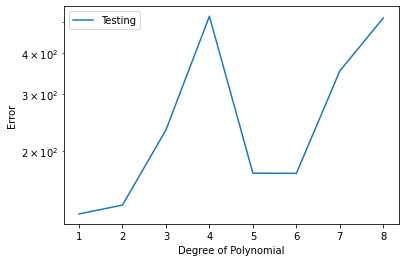

In [59]:
errs = np.copy(np.array(errors)).T
test = errs[0:8]
# train = errs[1][0:7]
plot_all(x = range(1,9), hs = [test],ylog = True,  legends = ['Testing'], xl ='Degree of Polynomial', yl ='Error')

Choosing Optimal degree 7, i.e. M = 8

In [18]:
lamdas = [pow(10,i) for i in np.arange(-30,0,0.5)]
errors = [Cross_Validation(phi,t, alpha = 1e-4, batch_size = 1, parts = 10, lamda = lamda, m = 8, pinv = True) for lamda in lamdas]

3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3.1280332259654897 0.983124095463632
3

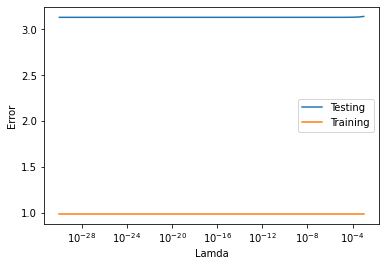

In [22]:
errs = np.array(errors).copy().T
m = 55
train = errs[1][0:m]
test =errs[0][0:m]
lambs = np.copy(lamdas)
lambs = lambs[0:m]
plot_all(x = lambs, hs = [test,train], xlog = True,  legends = ['Testing','Training'], xl ='Lamda', yl ='Error',)

Hence we take the lamda as 0 since this doesn't vary

1.9583761930193984
-4.272631422023542 2.6816195694229608 6.954250991446503
-1.2545318801016058e-07


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

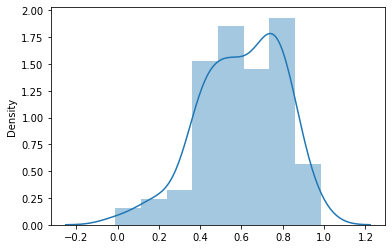

In [147]:
wx,costx = MPPI(phi  = phi,t = t, lamda = 1e-6, m = 8)

hx = get(phi,8).dot(wx)
noise1 = hx - t
mx = np.max(noise1)
mn = np.min(noise1)
print(np.std(noise1)**2)
print(mn,mx,mx-mn)
noises = [noise/7 + 0.6 for noise in noise1]      # Normalising the noise from (-4,4) to (-1/2,1/2)
print(np.mean(noise1))
# sns.distplot(noise1,kde = True)
sns.distplot(noises)

In [5]:
# print(noises)
print(np.mean(noises))

-1.5681648501270073e-08


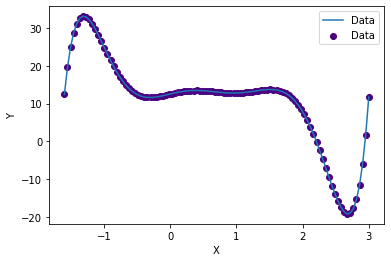

In [8]:
#plot_all(x,[hx,hx],xl='X',yl='Y',scatterFirst=True,legends=['Data','Data'])
plt.plot(x,t)

In [65]:
noises = np.copy(np.array(noises))
sum(noises)
mean = 0

100


mean = 0.5
mode = 0.6

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

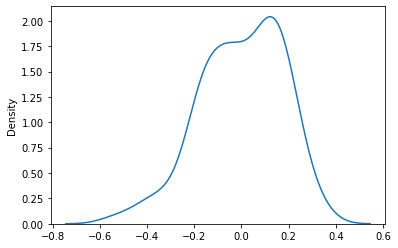

In [14]:
sns.distplot(noises, hist = False, kde = True)

Plot for alpha = 2.4, beta = 1.6
       Noise   Samples
0   0.551330  0.390839
1   0.673253  0.640155
2   0.802636  0.722253
3   0.508736  0.885025
4   0.650033  0.648600
..       ...       ...
95  0.457358  0.508378
96  0.418080  0.956039
97  0.797156  0.757568
98  0.739567  0.706753
99  0.528381  0.834238

[100 rows x 2 columns]


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-0.5, 1.5)

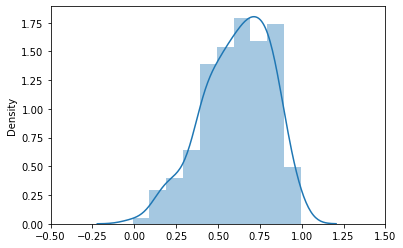

In [142]:
al=2.4
be=1.6
print("Plot for alpha = {}, beta = {}".format(al,be))
samples = np.random.beta(al,be, size=100)
datas = {'Noise': noises, 'Samples' : samples}
dfs = pd.DataFrame(datas)
print(dfs)
sns.distplot(dfs).set_xlim(-1/2,3/2)